In [ ]:
%matplotlib inline
import os
import sys
import functools
from collections import Counter
import pylab as plt
import numpy as np
import fitsio
from astrometry.util.fits import fits_table, merge_tables
from astrometry.util.util import Tan
from astrometry.util.starutil_numpy import degrees_between
from astrometry.util.plotutils import plothist
from astrometry.libkd.spherematch import match_radec, tree_build_radec, tree_search_radec, tree_open
sys.path.insert(0, 'legacypipe/py')
from legacypipe.gaiacat import GaiaCatalog
from legacypipe.reference import fix_tycho, fix_gaia, merge_gaia_tycho
os.environ['GAIA_CAT_DIR'] = '/global/cfs/cdirs/cosmo/work/gaia/chunks-gaia-dr2-astrom-2/'

In [ ]:
#tiles = fits_table('/global/cfs/cdirs/desi/users/djschleg/tiling/tiles-4112packing-2021-03-28.fits')
#tiles = fits_table('/global/cfs/cdirs/desi/users/schlafly/tiling/tiles-4112-packing-20210322-decorated.fits')

#tag = '4112-packing-20210328'
tag = '4112-packing-20210329'

tiles = fits_table('/global/cfs/cdirs/desi//users/schlafly/tiling/tiles-%s-decorated.fits' % tag)

In [ ]:
tiles.about()

In [189]:
if False:
    plt.plot(tiles.centerid);
    plt.show()
    plt.plot(tiles.get('pass'));
    plt.show()
    plt.plot(tiles.program)

In [ ]:
I = np.flatnonzero(tiles.in_imaging)
plt.plot(tiles.ra[I], tiles.dec[I], 'k.', alpha=0.1);

In [127]:
T = fits_table('/global/cfs/cdirs/desi/users/ameisner/GFA/gfa_reduce_etc/gfa_wcs+focus.bigtan-zenith.fits')

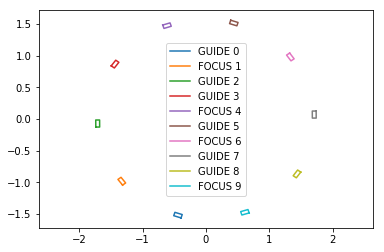

In [159]:
# Aaron's file above has all images share the boresight CRVAL and large CRPIX values.
rel_xy = {}
for t in T:
    wcs = Tan(0., 0., t.crpix[0], t.crpix[1],
            t.cd[0,0], t.cd[0,1], t.cd[1,0], t.cd[1,1], 
            float(t.naxis[0]), float(t.naxis[1]))
    ctype = t.extname[:5]
    cnum = int(t.extname[5])
    rel_xy[(ctype,cnum)] = (0.,0.,wcs)

maxr = 0.
for k,(tx,ty,wcs) in rel_xy.items():
    (gstr,gnum) = k
    h,w = wcs.shape
    x,y = [1,1,w,w,1],[1,h,h,1,1]
    r,d = wcs.pixelxy2radec(x, y)
    dists = degrees_between(0., 0., r, d)
    maxr = max(maxr, max(dists))
    r[r>180] -= 360.
    plt.plot(r, d, '-', label='%s %i' % (gstr, gnum))
plt.legend();
plt.axis('equal');    

In [160]:
all_sub_wcs = {}
for (cstr,cnum),(tx,ty,wcs) in rel_xy.items():
    if cstr == 'FOCUS':
        # add the two half-chips.
        # wcs.get_subimage moves the CRPIX, but leave CRVAL unchanged, so tx,ty still work unchanged.
        all_sub_wcs[(cstr, cnum, 1)] = (tx, ty, wcs.get_subimage(50, 1, 1024, 1032))
        all_sub_wcs[(cstr, cnum, 2)] = (tx, ty, wcs.get_subimage(1174, 1, 1024, 1032))
        # Add (negative) margin for donut size and telescope pointing uncertainty.
        # ~10" for donuts and ~10" for telescope pointing
        margin = 100
        all_sub_wcs[(cstr, cnum, -1)] = (tx, ty, wcs.get_subimage(50+margin, 1+margin, 1024-2*margin, 1032-2*margin))
        all_sub_wcs[(cstr, cnum, -2)] = (tx, ty, wcs.get_subimage(1174+margin, 1+margin, 1024-2*margin, 1032-2*margin))
    else:
        # Guide chips include overscan pixels -- including a blank region in the middle.
        #print(cstr,cnum, 'shape', wcs.shape)
        all_sub_wcs[(cstr, cnum, 0)] = (tx, ty, wcs)
        # Add expanded GUIDE chips -- 25" margin / 0.2"/pix = 125 pix
        margin = 125
        h,w = wcs.shape
        all_sub_wcs[(cstr, cnum, -1)] = (tx, ty, wcs.get_subimage(-margin, -margin, w+2*margin, h+2*margin))

In [142]:
Nbright = 10
tiles_ann = fits_table()
#tiles_ann.centerid = tiles.centerid

keys = list(all_sub_wcs.keys())
keys.sort()
wcs_regions = []
for k in keys:
    tx,ty,wcs = all_sub_wcs[k]
    ctype,cnum,half = k
    if half == 0:
        name = '%s_%i' % (ctype.lower(), cnum)
    elif half == -1 and ctype=='GUIDE':
        # expanded guide
        name = '%s_%i_margin' % (ctype.lower(), cnum)
    elif half <= -1:
        # reduced focus
        name = '%s_%i_%s_margin' % (ctype.lower(), cnum, chr(ord('a')-1+np.abs(half)))
    else:
        name = '%s_%i_%s' % (ctype.lower(), cnum, chr(ord('a')-1+half))
    arr = np.zeros(len(tiles), (np.float32, Nbright))
    tiles_ann.set('brightest_'+name, arr)        
    wcs_regions.append((name, tx, ty, wcs, arr))

In [146]:
class CachingGaiaCatalog(GaiaCatalog):
    def __init__(self, columns=None, **kwargs):
        super().__init__(**kwargs)
        self.columns = columns

    def get_healpix_catalog(self, healpix):
        #return super().get_healpix_catalog(healpix)
        from astrometry.util.fits import fits_table
        fname = self.fnpattern % dict(hp=healpix)
        #print('Reading', fname)
        return fits_table(fname, columns=self.columns)

    def get_healpix_catalogs(self, healpixes):
        from astrometry.util.fits import merge_tables
        cats = []
        for hp in healpixes:
            cats.append(self.get_healpix_catalog(hp))
        if len(cats) == 1:
            return cats[0].copy()
        return merge_tables(cats)

    @functools.lru_cache(maxsize=4000)
    def get_healpix_tree(self, healpix):
        from astrometry.util.fits import fits_table
        fname = self.fnpattern % dict(hp=healpix)
        tab = fits_table(fname, columns=self.columns)
        kd = tree_build_radec(tab.ra, tab.dec)
        return (kd,tab)
    
    def get_healpix_rangesearch_catalogs(self, healpixes, rc, dc, rad):
        cats = []
        for hp in healpixes:
            (kd,tab) = self.get_healpix_tree(hp)
            I = tree_search_radec(kd, rc, dc, rad)
            if len(I):
                cats.append(tab[I])
        if len(cats) == 1:
            return cats[0] #.copy()
        return merge_tables(cats)
    
    def get_catalog_in_wcs(self, wcs, step=100., margin=10):
        # Grid the CCD in pixel space
        W,H = wcs.get_width(), wcs.get_height()
        xx,yy = np.meshgrid(
            np.linspace(1-margin, W+margin, 2+int((W+2*margin)/step)),
            np.linspace(1-margin, H+margin, 2+int((H+2*margin)/step)))
        # Convert to RA,Dec and then to unique healpixes
        ra,dec = wcs.pixelxy2radec(xx.ravel(), yy.ravel())
        healpixes = set()
        for r,d in zip(ra,dec):
            healpixes.add(self.healpix_for_radec(r, d))

        # Read catalog in those healpixes
        rc,dc = wcs.radec_center()
        rad = wcs.radius()
        cat = self.get_healpix_rangesearch_catalogs(healpixes, rc, dc, rad)

        if len(cat) == 0:
            return cat
        # Cut to sources actually within the CCD.
        _,xx,yy = wcs.radec2pixelxy(cat.ra, cat.dec)
        cat.x = xx
        cat.y = yy
        onccd = np.flatnonzero((xx >= 1.-margin) * (xx <= W+margin) *
                               (yy >= 1.-margin) * (yy <= H+margin))
        cat.cut(onccd)
        return cat

gaia = CachingGaiaCatalog(columns=['ra','dec','phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'astrometric_excess_noise',
                                  'astrometric_params_solved', 'source_id', 'pmra_error', 'pmdec_error', 'parallax_error',
                                  'ra_error', 'dec_error', 'pmra', 'pmdec', 'parallax', 'ref_epoch'])

In [144]:
tyc2fn = '/global/cfs/cdirs/cosmo/staging/tycho2/tycho2.kd.fits'
tycho_kd = tree_open(tyc2fn)
tycho_cat = fits_table(tyc2fn)

In [180]:
plots = False

maxrad = maxr * 1.05
for itile,tile in enumerate(tiles):
    if not tile.in_imaging:
        continue
    if tile.centerid % 10 == 0:
        print('tile', tile.centerid, gaia.get_healpix_tree.cache_info())

    I = tree_search_radec(tycho_kd, tile.ra, tile.dec, maxrad)
    tycstars = tycho_cat[I]
    fix_tycho(tycstars)
    
    if plots:
        plt.clf()

    #tilewcs.set_crval(tile.ra, tile.dec)

    for name,tx,ty,chipwcs,brightest in wcs_regions:
        # Move each GFA chip's center relative to the tile WCS.
        h,w = chipwcs.shape
        #r,d = tilewcs.pixelxy2radec(tx, ty)
        #chipwcs.set_crval(r, d)

        chipwcs.set_crval(tile.ra, tile.dec)
        
        stars = gaia.get_catalog_in_wcs(chipwcs, step=1032, margin=0)
        if len(stars) == 0:
            print('No stars in tile centerid', tile.centerid, 'chip', name)
            continue
        ok,x,y = chipwcs.radec2pixelxy(stars.ra, stars.dec)
        if plots:
            cx,cy = [1,1,w,w,1],[1,h,h,1,1]
            cornr,cornd = chipwcs.pixelxy2radec(cx, cy)
            plt.plot(cornr, cornd, '-')        
            plt.plot(stars.ra, stars.dec, 'k.')
            plt.title(name)
            plt.show()
        J = np.flatnonzero((x >= 1) * (y >= 1) * (x <= w) * (y <= h))
        if len(J) == 0:
            continue
        gstars = stars[J]
        fix_gaia(gstars)

        ok,x,y = chipwcs.radec2pixelxy(tycstars.ra, tycstars.dec)
        J = np.flatnonzero((x >= 1) * (y >= 1) * (x <= w) * (y <= h))
        if len(J):
            tstars = tycstars[J]
            merge_gaia_tycho(gstars, tstars)
            stars = merge_tables([gstars, tstars], columns='fillzero')
        else:
            stars = gstars
        mag = stars.mag
        K = np.argsort(mag)
        K = K[:Nbright]
        #print('Brightest stars in tile', tile.centerid, name, ':', ', '.join(['%.2f'%m for m in wstars.mag[K]]))
        brightest[itile, :len(K)] = mag[K]

    if plots:
        plt.show()
    if tile.get('pass') > 0:
        break

tile 70 CacheInfo(hits=68449, misses=5623, maxsize=4000, currsize=4000)
tile 90 CacheInfo(hits=68667, misses=5623, maxsize=4000, currsize=4000)
tile 110 CacheInfo(hits=69045, misses=5663, maxsize=4000, currsize=4000)
tile 120 CacheInfo(hits=69325, misses=5693, maxsize=4000, currsize=4000)
tile 130 CacheInfo(hits=69609, misses=5722, maxsize=4000, currsize=4000)
tile 140 CacheInfo(hits=69904, misses=5735, maxsize=4000, currsize=4000)
tile 150 CacheInfo(hits=70179, misses=5766, maxsize=4000, currsize=4000)
tile 250 CacheInfo(hits=70846, misses=5813, maxsize=4000, currsize=4000)
tile 260 CacheInfo(hits=70880, misses=5815, maxsize=4000, currsize=4000)
tile 310 CacheInfo(hits=71212, misses=5853, maxsize=4000, currsize=4000)
tile 320 CacheInfo(hits=71433, misses=5882, maxsize=4000, currsize=4000)
tile 350 CacheInfo(hits=72036, misses=5957, maxsize=4000, currsize=4000)
tile 360 CacheInfo(hits=72318, misses=5974, maxsize=4000, currsize=4000)
tile 490 CacheInfo(hits=72842, misses=6032, maxsize=4

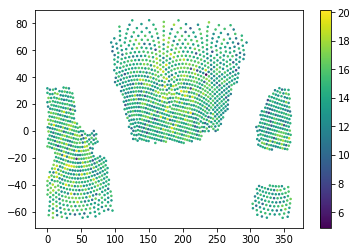

In [181]:
I = np.flatnonzero(tiles_ann.brightest_focus_1_a[:,0])
plt.scatter(tiles.ra[I], tiles.dec[I], c=tiles_ann.brightest_focus_1_a[I,0], marker='.', s=9);
plt.colorbar();

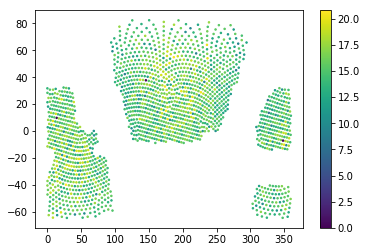

In [191]:
#I = np.flatnonzero(tiles_ann.brightest_focus_1_a_margin[:,0])
I = np.flatnonzero((tiles.get('pass')==0) * (tiles.program == 'dark') * tiles.in_imaging)
plt.scatter(tiles.ra[I], tiles.dec[I], c=tiles_ann.brightest_focus_1_a_margin[I,0], marker='.', s=9);
plt.colorbar();

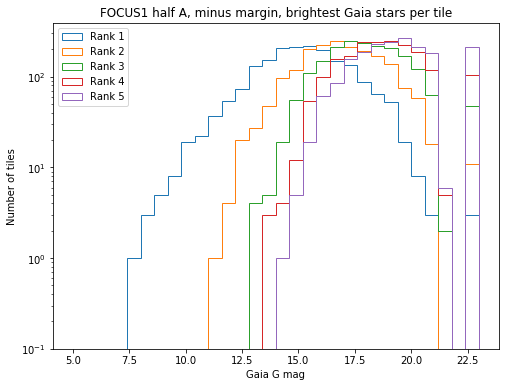

In [192]:
plt.figure(figsize=(8,6))
bright = 5
faint = 23
ha = dict(histtype='step', range=(bright,faint), bins=30, log=True)

c = 'brightest_focus_1_a_margin'

K = np.flatnonzero((tiles.program == 'dark') * (tiles.get('pass') == 0) * (tiles.in_imaging))
for j in range(5):
    arr = tiles_ann.get(c)[K,j]
    J, = np.nonzero(arr == 0)
    arr[J] = faint
    plt.hist(np.clip(arr, bright, faint), label='Rank %i'%(j+1), **ha);
plt.title('FOCUS1 half A, minus margin, brightest Gaia stars per tile')
plt.xlabel('Gaia G mag')
plt.ylabel('Number of tiles')
plt.legend(loc='upper left');
plt.savefig('focus1a-brightest.png')

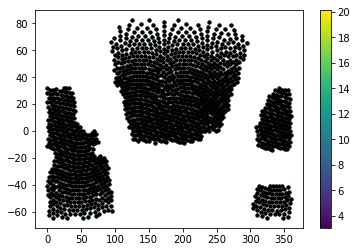

In [177]:
I = np.flatnonzero(tiles_ann.brightest_focus_1_a[:,0])
plt.scatter(tiles.ra[I], tiles.dec[I], c=tiles_ann.brightest_focus_1_a[I,0], marker='.', s=9);
plt.colorbar();
c = 'brightest_focus_1_a_margin'
J = np.flatnonzero((tiles.get('pass') == 0) * (tiles.in_imaging) * (tiles_ann.get(c)[:,0] == 0))
plt.plot(tiles.ra[J], tiles.dec[J], 'k.')

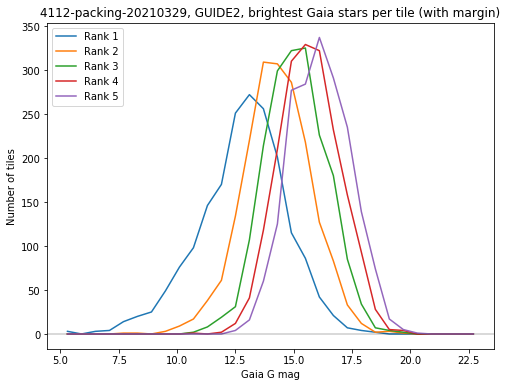

In [193]:
plt.figure(figsize=(8,6))
mx = 5
#ha = dict(histtype='step', range=(mx,23), bins=30)
for j in range(5):
    c = 'brightest_guide_2_margin'
    J, = np.nonzero(tiles_ann.get(c)[I,j])
    n,e = np.histogram(np.maximum(mx, tiles_ann.get(c)[I[J],j]), bins=30, range=(mx,23))
    emid = (e[:-1]+e[1:])/2.
    p = plt.plot(emid, n, '-', label='Rank %i'%(j+1))
    #c = 'brightest_guide_2_margin'
    #n,e = np.histogram(np.maximum(mx, tiles_ann.get(c)[I[J],j]), bins=30, range=(mx,23))
    #plt.plot(emid, n, '--', color=p[0].get_color(), label='Rank %i (w / margin)'%(j+1))
plt.axhline(0., color='k', alpha=0.2)
plt.title('%s, GUIDE2, brightest Gaia stars per tile (with margin)' % tag)
plt.xlabel('Gaia G mag')
plt.ylabel('Number of tiles')
plt.legend(loc='upper left');
plt.savefig('guide2-brightest.png')

In [ ]:
tiles_ann.about()

In [ ]:
len(tiles)

In [ ]:
tiles.add_columns_from(tiles_ann)

In [ ]:
tiles.writeto('tiles-%s-decorated-brightest.fits' % tag)

In [ ]:
tilewcs.set_crval(skyra, skydec)

for (ctype,cnum),(tx,ty,wcs) in rel_xy.items():
    r,d = tilewcs.pixelxy2radec(tx, ty)
    wcs.set_crval(r, d)
    stars = gaia.get_catalog_in_wcs(wcs, step=1032, margin=0)
    fix_gaia(stars)
    print(ctype, cnum, ':', len(stars), 'Gaia stars')
    ok,x,y = wcs.radec2pixelxy(stars.ra, stars.dec)
    ext = '%s%i' % (ctype,cnum)
    if ctype == 'FOCUS':
        img = F[ext].read()
        print(img.shape)
        #img = img[0,:,:]
        img = np.hstack((img[:1032, 50:1074], img[:1032, 1174:2198]))
        print(img.shape)
    else:
        img = G[ext].read()
        #img = np.hstack((img[:,50:1074], img[:,1174:2198]))
        #print(img.shape)
    K = np.argsort(stars.mag)
    K = K[:10]
    mn,mx = np.percentile(img.ravel(), [50,98])
    plt.figure(figsize=(10,5))
    plt.imshow(img, vmin=mn, vmax=mx, origin='lower', cmap='gray')
    ax = plt.axis()
    plt.plot(x[K]-1, y[K]-1, 'o', mew=2, mec='r', mfc='none', ms=20)
    plt.axis(ax)
    plt.title(ext)
    plt.show()
    